<a href="https://colab.research.google.com/github/PyBeginner1/PredictingCryptoPrice/blob/main/Predicting_CryptoPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import datetime as dt


In [2]:
crypto_currency = 'ETH'
#to check 1ETH = 'x' USD
against_currency = 'USD'

In [7]:
#time frame for training data to predfict future
start = dt.datetime(2016, 1, 1)
#today
end = dt.datetime.today()

In [9]:
data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)

In [11]:
print(data.head())

                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2016-01-01  0.954822  0.931442  0.933712  0.948024  206062.0   0.948024
2016-01-02  0.969637  0.936560  0.947401  0.937124  255504.0   0.937124
2016-01-03  0.991362  0.934313  0.938430  0.971905  407632.0   0.971905
2016-01-04  0.976438  0.929835  0.972045  0.954480  346245.0   0.954480
2016-01-05  0.970597  0.946543  0.953147  0.950176  219833.0   0.950176


In [12]:
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-05-03,3523.585938,3180.742676,3431.131592,3253.629395,6.240205e+10,3253.629395
2021-05-04,3541.462646,3213.101562,3240.554688,3522.783203,4.833420e+10,3522.783203
2021-05-05,3598.895996,3386.239990,3524.930908,3490.880371,4.430039e+10,3490.880371
2021-05-06,3807.253906,3370.261963,3490.105225,3484.729004,3.960724e+10,3484.729004
2021-05-08,3630.603027,3462.247803,3486.229492,3615.113037,3.950773e+10,3615.113037


In [17]:
#prepare the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [14]:
#using x days data of past to predict future, here we take 60 days data from past
prediction_days =60

In [19]:
#training data
x_train, y_train =[], []
for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  #61st day that is the next day
  y_train.append(scaled_data[x,0])


In [22]:
#converting to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [28]:
#create neural network
model = Sequential()

model.add(LSTM(units=50, return_sequences =True, input_shape=(x_train.shape[1],1)))
#to reduce overfitting
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences =True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train,y_train, epochs = 25, batch_size =32)

Epoch 1/25
60/60 [==============================] - 9s 74ms/step - loss: 0.0069
Epoch 2/25
60/60 [==============================] - 5s 79ms/step - loss: 0.0017
Epoch 3/25
60/60 [==============================] - 5s 78ms/step - loss: 0.0012
Epoch 4/25
60/60 [==============================] - 5s 78ms/step - loss: 8.5568e-04
Epoch 5/25
60/60 [==============================] - 5s 79ms/step - loss: 9.0128e-04
Epoch 6/25
60/60 [==============================] - 5s 78ms/step - loss: 7.3470e-04
Epoch 7/25
60/60 [==============================] - 5s 79ms/step - loss: 0.0011
Epoch 8/25
60/60 [==============================] - 5s 79ms/step - loss: 9.2990e-04
Epoch 9/25
60/60 [==============================] - 5s 79ms/step - loss: 8.6225e-04
Epoch 10/25
60/60 [==============================] - 5s 79ms/step - loss: 5.8680e-04
Epoch 11/25
60/60 [==============================] - 5s 79ms/step - loss: 5.5977e-04
Epoch 12/25
60/60 [==============================] - 5s 80ms/step - loss: 5.8526e-04
Epoch

In [29]:
#testing the model
#time frame
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.today()

test_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

In [31]:
#combine 
total_dataset = pd.concat((data['Close'], test_data['Close']),axis = 0)

In [33]:
model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs =model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

Making Predictions

In [35]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1))

In [37]:
prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

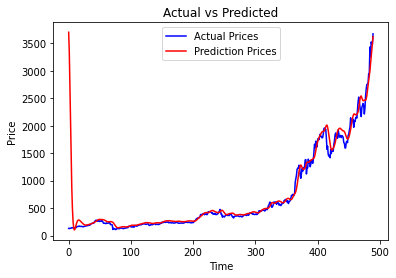

In [47]:
#plot
plt.plot(actual_prices, color = 'blue', label ="Actual Prices")
plt.plot(prediction_prices, color ='red', label="Prediction Prices")
plt.xlabel("Time")
plt.ylabel('Price')
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

In [48]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs) + 1, 0 ]]
real_data = np.array(real_data)
real_data  = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [49]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

[[3707.565]]
